In [1]:
%matplotlib inline
import pandas as pd
from os.path import join
import seaborn as sns
import numpy as np
from stats import mc_t_two_sample
import itertools
from IPython.display import SVG, display
import xml.etree.ElementTree as ET
ET.register_namespace("","http://www.w3.org/2000/svg")


/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##Load the mapping file and add columns for each "swatch"


In [2]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
alpha_div_fp = join(home, 'core_div_out/arare_max1000/alpha_div_collated/PD_whole_tree.txt')

In [3]:
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md['Meta'] = sample_md.Description.apply(lambda x: '.'.join(x.split('.')[:3]))
sample_md = sample_md.drop(['16SITS', 'BarcodeSequence', 'BlankExtraction'], axis=1)
sample_md['Swatch'] = sample_md['PlateLocation'].apply(lambda x: x.upper()[0]).values + '.' + sample_md['Row'].astype(str) + '.' + sample_md['Material'].apply(lambda x: x.title()[:2]).values

##Filter the replicate ID's

In [4]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [5]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md = sample_md.drop(reps, inplace=False)

##Create map to svg
The svg was created with illustrator. Each surface of interest has a unique color so that we can map new colors to it

In [6]:
swatches = {'#1FFFFF':'F.3.Ca', '#2FFFFF':'F.3.Ce', '#3FFFFF':'F.3.Dr',
            '#4FFFFF':'F.2.Ca', '#5FFFFF':'F.2.Ce', '#6FFFFF':'F.2.Dr',
            '#7FFFFF':'W.3.Ca', '#8FFFFF':'W.3.Ce', '#9FFFFF':'W.3.Dr',
            '#10FFFF':'W.2.Ca', '#11FFFF':'W.2.Ce', '#12FFFF':'W.2.Dr',
            '#13FFFF':'C.3.Ca', '#14FFFF':'C.3.Ce', '#15FFFF':'C.3.Dr',
            '#16FFFF':'C.2.Ca', '#17FFFF':'C.2.Ce', '#18FFFF':'C.2.Dr'}

inv_swatches = {v: k for k, v in swatches.items()}
sample_md['SvgCols'] = sample_md.Swatch.map(inv_swatches)

##Add the alpha diversity metrics to the mapping file


In [7]:
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '1000' in e]
alpha_div = alpha_div[alpha_cols]
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)
sample_md['MedianAlpha'] = sample_md[alpha_cols].median(axis=1)

##Define a function that will take map values to the svg

In [8]:
def color_plot(df, output):
    tree = ET.parse('office1.svg')
    root = tree.getroot()
    for child in root:
        if 'fill' in child.attrib:
            if child.attrib['fill'] in df.SvgCols.values:
                child.attrib['fill'] = df[df['SvgCols'] == child.attrib['fill']]['Colors'].values.astype(str)[0]
            elif child.attrib['fill'] in swatches.keys():
                child.attrib['fill'] = '#FFFFFF'
    tree.write(output)

#Map colors to the office SVG 

Illustrate what this will look like

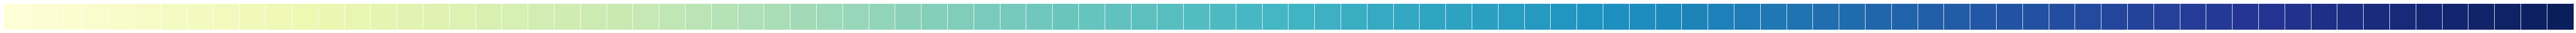

In [9]:
colors = sns.color_palette("YlGnBu", int(np.ceil(sample_md.MeanAlpha.max() - sample_md.MeanAlpha.min())))
sns.palplot(colors)

In [10]:
col_interest = 'MeanAlpha'

In [11]:
alpha_colors = sample_md[[col_interest, 'City', 'OfficeNumber', 'Description', 'Event', 'Swatch', 'SvgCols']]
alpha_colors = alpha_colors[(alpha_colors['City'] == 'sandiego') & 
             (alpha_colors['OfficeNumber'] == '1') & 
             (alpha_colors['Event'] == '70')]

alpha_colors = alpha_colors[alpha_colors[col_interest].notnull()]

In [12]:
colors = sns.color_palette("YlGnBu", int(np.ceil(alpha_colors[col_interest].max() - alpha_colors[col_interest].min())))
alpha_colors['Colors'] = [colors.as_hex()[int(e-alpha_colors[col_interest].min())] for e in alpha_colors[col_interest].values]

##Create a figure for every season, city, office combination (12 total)

In [13]:
df_fig = sample_md.groupby(['City', 'Period', 'Swatch']).agg('median').reset_index()
df_fig['SvgCols'] = df_fig.Swatch.map(inv_swatches)

In [14]:
col_interest = 'MeanAlpha'
colors = sns.color_palette("YlGnBu", int(np.ceil(df_fig[col_interest].max() - df_fig[col_interest].min())))
df_fig['Colors'] = [colors.as_hex()[int(e-df_fig[col_interest].min())] for e in df_fig[col_interest].values]

In [15]:
for city in df_fig.City.unique():
    for period in df_fig.Period.unique():
        color_plot(df_fig[(df_fig['City'] == city) & (df_fig['Period'] == period)], '{0}_{1}.svg'.format(city, period))

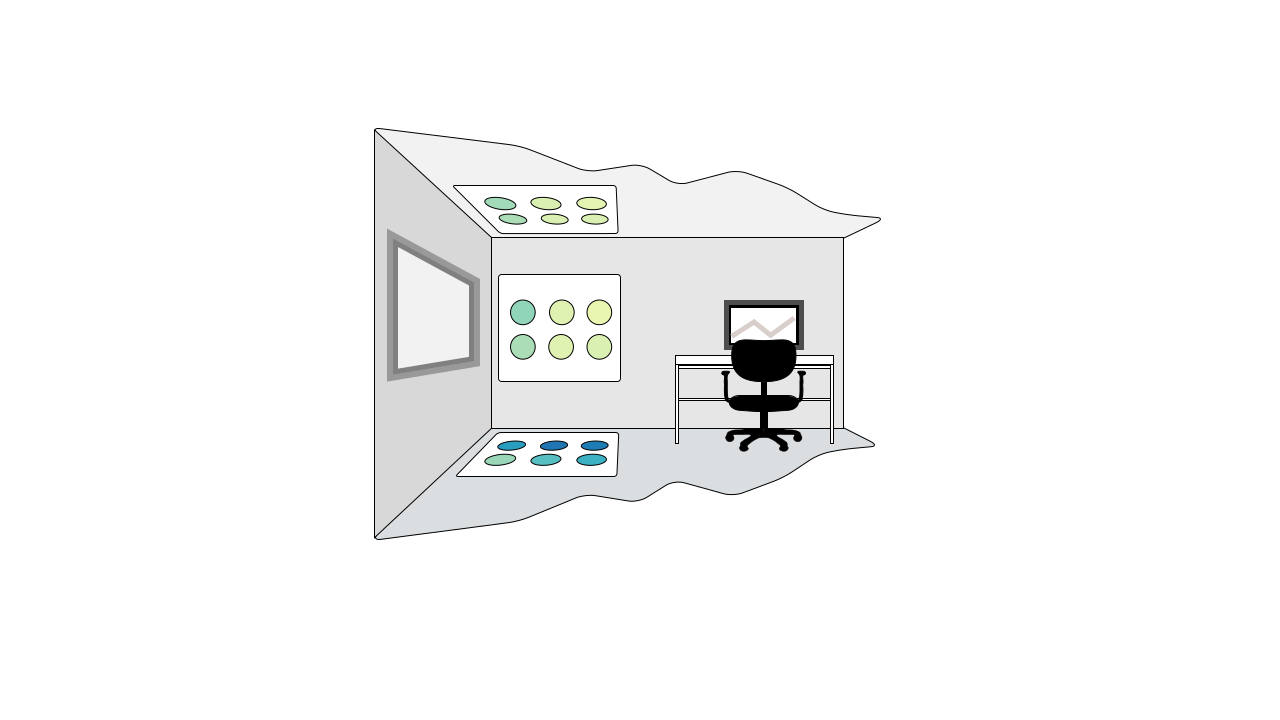

In [16]:
SVG(filename='flagstaff_1.svg')

##Alpha Diversity statistics

##Get statisitics for period 1 vs all other periods for all cities

negative values in the following statistics indicate that that the period on the left is less diverse than the period on the right

In [17]:
for city in sample_md.City.unique():
    for period1, period2 in itertools.combinations(sample_md.Period.unique(), 2):
        per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period1)]['MeanAlpha'].values) 
        per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period2)]['MeanAlpha'].values)
        obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
        print('City {0} Period {1}-Period {2} t-stat: {3} p-value: {4} n=({5}, {6})'.format(city, 
                                                                                            period1, 
                                                                                            period2, 
                                                                                            obs_t, 
                                                                                            param_p_val, 
                                                                                            len(per_1),
                                                                                            len(per_2)))
    print('\n')

City flagstaff Period 1-Period 3 t-stat: -5.3921848193025745 p-value: 1.2529272711768162e-07 n=(230, 137)
City flagstaff Period 1-Period 2 t-stat: -3.1684160036776112 p-value: 0.0016713337225163151 n=(230, 113)
City flagstaff Period 1-Period 4 t-stat: -0.1572455000169197 p-value: 0.8751333759296064 n=(230, 159)
City flagstaff Period 3-Period 2 t-stat: 1.4883045997054063 p-value: 0.13794102677082898 n=(137, 113)
City flagstaff Period 3-Period 4 t-stat: 3.9495599783164397 p-value: 9.806690321556566e-05 n=(137, 159)
City flagstaff Period 2-Period 4 t-stat: 2.255130360929652 p-value: 0.024926233878212578 n=(113, 159)


City sandiego Period 1-Period 3 t-stat: -7.9060762878411746 p-value: 4.7800646705579597e-14 n=(194, 116)
City sandiego Period 1-Period 2 t-stat: -11.020648353688685 p-value: 7.995686451708489e-24 n=(194, 98)
City sandiego Period 1-Period 4 t-stat: -4.84029089462673 p-value: 1.8533977652925293e-06 n=(194, 209)
City sandiego Period 3-Period 2 t-stat: -1.9603822231506167 p-valu

In [18]:
for period in sample_md.Period.unique():
    for city1, city2 in itertools.combinations(sample_md.City.unique(), 2):
        per_1 = list(sample_md[(sample_md['City'] == city1) & (sample_md['Period'] == period)]['MeanAlpha'].values) 
        per_2 = list(sample_md[(sample_md['City'] == city2) & (sample_md['Period'] == period)]['MeanAlpha'].values)
        obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
        print('Period {0} {1}-{2} t-stat: {3} p-value: {4} n=({5}, {6})'.format(period, 
                                                                              city1, 
                                                                              city2, 
                                                                              obs_t, 
                                                                              param_p_val, 
                                                                              len(per_1),
                                                                              len(per_2)))
    print('\n')

Period 1 flagstaff-sandiego t-stat: 8.682625965722735 p-value: 2.220446049250313e-16 n=(230, 194)
Period 1 flagstaff-toronto t-stat: 8.356006761491841 p-value: 1.1102230246251565e-15 n=(230, 164)
Period 1 sandiego-toronto t-stat: -0.18791861155268683 p-value: 0.8510475175045024 n=(194, 164)


Period 3 flagstaff-sandiego t-stat: 3.7340156752693208 p-value: 0.00023322128345593107 n=(137, 116)
Period 3 flagstaff-toronto t-stat: 4.21315139040889 p-value: 3.523351927881002e-05 n=(137, 114)
Period 3 sandiego-toronto t-stat: 0.6818525768102427 p-value: 0.4960242266452579 n=(116, 114)


Period 2 flagstaff-sandiego t-stat: 0.29616069703985154 p-value: 0.7674014312914266 n=(113, 98)
Period 2 flagstaff-toronto t-stat: 2.878768885736491 p-value: 0.0044221044475656335 n=(113, 91)
Period 2 sandiego-toronto t-stat: 3.047671049547323 p-value: 0.0026400839503049056 n=(98, 91)


Period 4 flagstaff-sandiego t-stat: 2.085956942862932 p-value: 0.037674552759484836 n=(159, 209)
Period 4 flagstaff-toronto t-

In [19]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.PlateLocation.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['PlateLocation'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['PlateLocation'] == loc2)]['MeanAlpha'].values)
            obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
            print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                              city, 
                                                                                              loc1, 
                                                                                              loc2,
                                                                                              obs_t,
                                                                                              param_p_val, 
                                                                                              len(per_1),
                                                                                              len(per_2)))
        print('\n')
    print('\n')

Period 1, City flagstaff ceiling-wall t-stat: 0.5194423649577766 p-value: 0.604223057920219 n=(72, 79)
Period 1, City flagstaff ceiling-floor t-stat: -6.177435843879747 p-value: 5.911650443517187e-09 n=(72, 79)
Period 1, City flagstaff wall-floor t-stat: -7.753143312158577 p-value: 1.0828383306625512e-12 n=(79, 79)


Period 1, City sandiego ceiling-wall t-stat: -0.5701173406835666 p-value: 0.5695527704952308 n=(68, 68)
Period 1, City sandiego ceiling-floor t-stat: -1.1175206388132446 p-value: 0.2659323042219073 n=(68, 58)
Period 1, City sandiego wall-floor t-stat: -0.3017900873850342 p-value: 0.763317642072358 n=(68, 58)


Period 1, City toronto ceiling-wall t-stat: -2.433365126820127 p-value: 0.01661601426536017 n=(53, 56)
Period 1, City toronto ceiling-floor t-stat: -3.5837557491043968 p-value: 0.0005133944429048103 n=(53, 55)
Period 1, City toronto wall-floor t-stat: -0.5565356476810297 p-value: 0.5789855499820891 n=(56, 55)




Period 3, City flagstaff ceiling-wall t-stat: -2.43001

In [20]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.Row.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Row'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Row'] == loc2)]['MeanAlpha'].values)
            try:
                obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
                print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                                  city, 
                                                                                                  loc1, 
                                                                                                  loc2,
                                                                                                  obs_t,
                                                                                                  param_p_val, 
                                                                                                  len(per_1),
                                                                                                  len(per_2)))
            except ValueError:
                print('not enough data')
    print('\n')

Period 1, City flagstaff 3-2 t-stat: -1.6423146346674624 p-value: 0.10190328924118058 n=(186, 44)
Period 1, City sandiego 3-2 t-stat: 1.210543584768246 p-value: 0.22755846687400338 n=(179, 15)
not enough data


Period 3, City flagstaff 3-2 t-stat: -1.6847041632138144 p-value: 0.09435613774370205 n=(75, 62)
Period 3, City sandiego 3-2 t-stat: -1.685464239282183 p-value: 0.0946344696831079 n=(69, 47)
Period 3, City toronto 3-2 t-stat: -2.6976677207849136 p-value: 0.008062648294712652 n=(58, 56)


Period 2, City flagstaff 3-2 t-stat: -1.9529096030478166 p-value: 0.05334770102246964 n=(69, 44)
Period 2, City sandiego 3-2 t-stat: -1.479511462482687 p-value: 0.1422777915856735 n=(74, 24)
Period 2, City toronto 3-2 t-stat: -2.031878813686489 p-value: 0.04514769357803452 n=(57, 34)


Period 4, City flagstaff 3-2 t-stat: -2.772665250166274 p-value: 0.006233220810323081 n=(120, 39)
Period 4, City sandiego 3-2 t-stat: -2.148512867397259 p-value: 0.03283433199782868 n=(148, 61)
Period 4, City toro

In [21]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.Material.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Material'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Material'] == loc2)]['MeanAlpha'].values)
            obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
            print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                              city, 
                                                                                              loc1, 
                                                                                              loc2,
                                                                                              obs_t,
                                                                                              param_p_val, 
                                                                                              len(per_1),
                                                                                              len(per_2)))
        print('\n')
    print('\n')

Period 1, City flagstaff ceiling-drywall t-stat: -0.5103845036090487 p-value: 0.6104560614580263 n=(86, 83)
Period 1, City flagstaff ceiling-carpet t-stat: -0.36562874986765614 p-value: 0.7151749574424537 n=(86, 61)
Period 1, City flagstaff drywall-carpet t-stat: 0.17966685769048332 p-value: 0.8576702394039486 n=(83, 61)


Period 1, City sandiego ceiling-drywall t-stat: -0.30939476449073683 p-value: 0.7575091038631819 n=(65, 69)
Period 1, City sandiego ceiling-carpet t-stat: -4.271677758283095 p-value: 3.8457335982097187e-05 n=(65, 60)
Period 1, City sandiego drywall-carpet t-stat: -4.12357493487952 p-value: 6.692361839981358e-05 n=(69, 60)


Period 1, City toronto ceiling-drywall t-stat: -0.9912507235119633 p-value: 0.3236998775890666 n=(59, 55)
Period 1, City toronto ceiling-carpet t-stat: -1.3078181943598959 p-value: 0.19373785893990036 n=(59, 50)
Period 1, City toronto drywall-carpet t-stat: -0.29294531467231144 p-value: 0.7701533130380047 n=(55, 50)




Period 3, City flagstaff ce

In [22]:
flagstaff = sample_md[sample_md['City'] == 'flagstaff']['MeanAlpha']
sandiego = sample_md[sample_md['City'] == 'sandiego']['MeanAlpha']
toronto = sample_md[sample_md['City'] == 'toronto']['MeanAlpha']

In [23]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(flagstaff, sandiego)
print(obs_t, param_p_val)

6.990490623483981 4.44022596469e-12


In [24]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(flagstaff, toronto)
print(obs_t, param_p_val)

9.11869786005203 0.0


In [25]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(sandiego, toronto)
print(obs_t, param_p_val)

2.352175443004232 0.0188303859485
